In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

2025-06-12 10:57:57.839089: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 10:57:57.841332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 10:57:57.862152: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 10:57:57.905696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749736677.938508   49940 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749736677.95

In [2]:
# data_path = r"C:\pastaImagensMangas"
data_path = "../../MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 50

In [3]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [4]:
df = df_maker(data_path)
df

,file_paths,labels
0,../../MangoLeaf/Powdery Mildew/20211109_121910...,Powdery Mildew
1,../../MangoLeaf/Powdery Mildew/20211109_122021...,Powdery Mildew
2,../../MangoLeaf/Powdery Mildew/IMG_20211107_11...,Powdery Mildew
3,../../MangoLeaf/Powdery Mildew/20211109_121919...,Powdery Mildew
4,../../MangoLeaf/Powdery Mildew/20211109_121938...,Powdery Mildew
...,...,...
3995,../../MangoLeaf/Sooty Mould/IMG_20211108_12092...,Sooty Mould
3996,../../MangoLeaf/Sooty Mould/IMG_20211108_12101...,Sooty Mould
3997,../../MangoLeaf/Sooty Mould/IMG_20211108_12082...,Sooty Mould
3998,../../MangoLeaf/Sooty Mould/IMG_20211212_14540...,Sooty Mould


In [5]:
train_df,test_val_df= train_test_split(df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=df["labels"])
test_df,val_df= train_test_split(test_val_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_val_df["labels"])

In [6]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


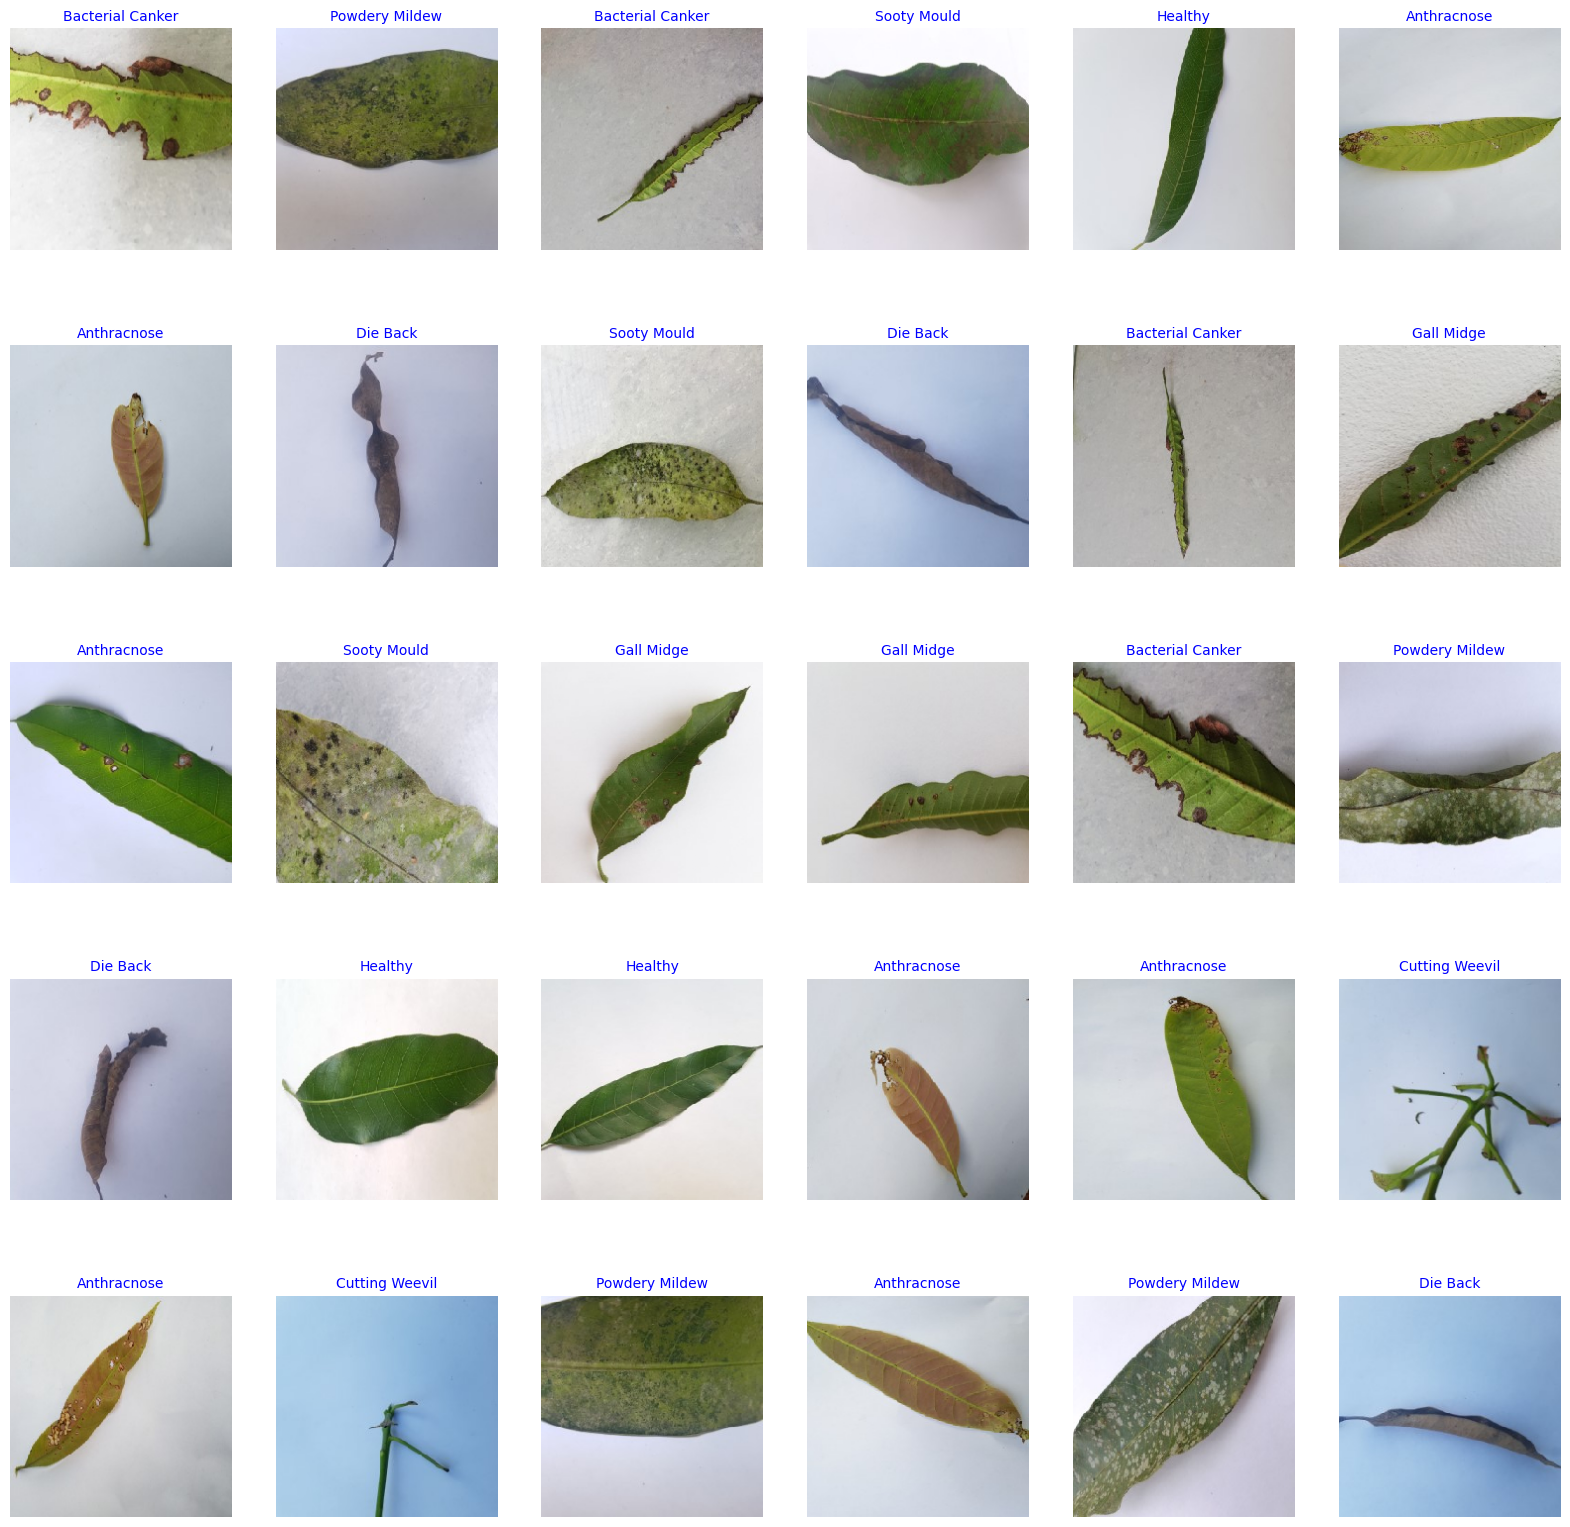

In [7]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 24))

for i in range(30):
    plt.subplot(6, 6, i + 1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

def create_mobilenetv3_model(input_shape, num_classes):
    # Base model (sem o top - camadas de classificação)
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        alpha=1.0,
        minimalistic=False,
        include_top=False,  # Remove as camadas de classificação
        weights='imagenet',  # Usar pesos pré-treinados
        input_tensor=None,
        pooling=None,
        dropout_rate=0.2,
        include_preprocessing=True
    )
    
    # Congelar as camadas do modelo base para transfer learning
    base_model.trainable = False
    
    # Adicionar camadas personalizadas para classificação
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Criar o modelo
input_shape = (224, 224, 3)
num_classes = len(classes)

model = create_mobilenetv3_model(input_shape, num_classes)

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Visualizar o modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,008 (3.87 MB)

 Trainable params: 74,888 (292.53 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [14]:
# Configurar callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Criar diretório para modelos se não existir
os.makedirs('../../v2/models', exist_ok=True)

# Definir callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Aguarda 5 épocas sem melhora
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'models/best_mobilenetv3_phase1.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Fase 1: Treinar apenas as camadas superiores
print("Fase 1: Treinamento com base congelada")

history_phase1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Número maior, mas early stopping controlará
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print(f"Fase 1 concluída. Parou na época: {len(history_phase1.history['loss'])}")

Fase 1: Treinamento com base congelada
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9926 - loss: 0.0267
Epoch 1: val_accuracy improved from -inf to 0.99750, saving model to models/best_mobilenetv3_phase1.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.9926 - loss: 0.0267 - val_accuracy: 0.9975 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9943 - loss: 0.0224
Epoch 2: val_accuracy did not improve from 0.99750
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 416ms/step - accuracy: 0.9943 - loss: 0.0223 - val_accuracy: 0.9950 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9909 - loss: 0.0220
Epoch 3: val_accuracy did not improve from 0.99750
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step - accuracy: 0.9910 - loss: 0.0219 - val_accuracy: 0.9975 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - a

In [16]:
# Fase 2: Fine-tuning com callbacks específicos
print("Fase 2: Fine-tuning")
model.get_layer('MobileNetV3Small').trainable = True

# Congelar as primeiras camadas
for layer in model.get_layer('MobileNetV3Small').layers[:-10]:
    layer.trainable = False

# Callbacks para fine-tuning (mais conservadores)
early_stopping_phase2 = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Mais paciência para fine-tuning
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_phase2 = ModelCheckpoint(
    'models/best_mobilenetv3_final.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_phase2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    min_lr=1e-8,
    verbose=1
)

# Recompilar com learning rate menor
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Número maior, mas early stopping controlará
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data),
    callbacks=[early_stopping_phase2, model_checkpoint_phase2, reduce_lr_phase2]
)

print(f"Fase 2 concluída. Parou na época: {len(history_phase2.history['loss'])}")
print("Treinamento concluído!")

Fase 2: Fine-tuning
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9965 - loss: 0.0171
Epoch 1: val_accuracy improved from -inf to 0.99750, saving model to models/best_mobilenetv3_final.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - accuracy: 0.9965 - loss: 0.0170 - val_accuracy: 0.9975 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9991 - loss: 0.0076
Epoch 2: val_accuracy did not improve from 0.99750
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.9991 - loss: 0.0076 - val_accuracy: 0.9975 - val_loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 3: val_accuracy did not improve from 0.99750
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 433ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9975 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy:

In [17]:
# Combinar históricos das duas fases para visualização
def combine_histories(hist1, hist2):
    """Combina os históricos de duas fases de treinamento"""
    combined_history = {}
    
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    
    return combined_history

# Combinar os históricos
combined_history = combine_histories(history_phase1, history_phase2)

# Criar DataFrame combinado
vals_combined = pd.DataFrame(combined_history)
vals_combined = vals_combined.rename(columns={
    "loss": "Train Loss",
    "val_loss": "Validation Loss",
    "accuracy": "Train Accuracy",
    "val_accuracy": "Validation Accuracy"
})

# Adicionar marcador para separar as fases
phase1_epochs = len(history_phase1.history['loss'])
vals_combined['Phase'] = ['Phase 1'] * phase1_epochs + ['Phase 2'] * len(history_phase2.history['loss'])
vals_combined['Epoch'] = range(1, len(vals_combined) + 1)

print(f"Fase 1: {phase1_epochs} épocas")
print(f"Fase 2: {len(history_phase2.history['loss'])} épocas")
print(f"Total: {len(vals_combined)} épocas")

Fase 1: 15 épocas
Fase 2: 10 épocas
Total: 25 épocas


In [21]:
# Visualização melhorada com separação das fases
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Accuracy', 'Loss'),
    vertical_spacing=0.1
)

# Accuracy
fig.add_trace(
    go.Scatter(x=vals_combined['Epoch'], y=vals_combined['Train Accuracy'], 
               name='Train Accuracy', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=vals_combined['Epoch'], y=vals_combined['Validation Accuracy'], 
               name='Validation Accuracy', line=dict(color='red')),
    row=1, col=1
)

# Loss
fig.add_trace(
    go.Scatter(x=vals_combined['Epoch'], y=vals_combined['Train Loss'], 
               name='Train Loss', line=dict(color='blue'), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=vals_combined['Epoch'], y=vals_combined['Validation Loss'], 
               name='Validation Loss', line=dict(color='red'), showlegend=False),
    row=2, col=1
)

# Adicionar linha vertical para separar as fases
fig.add_vline(x=phase1_epochs, line_dash="dash", line_color="green", 
              annotation_text="Fine-tuning starts")

fig.update_layout(
    title="MobileNetV3 Training Progress",
    template="plotly_dark",
    height=600
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

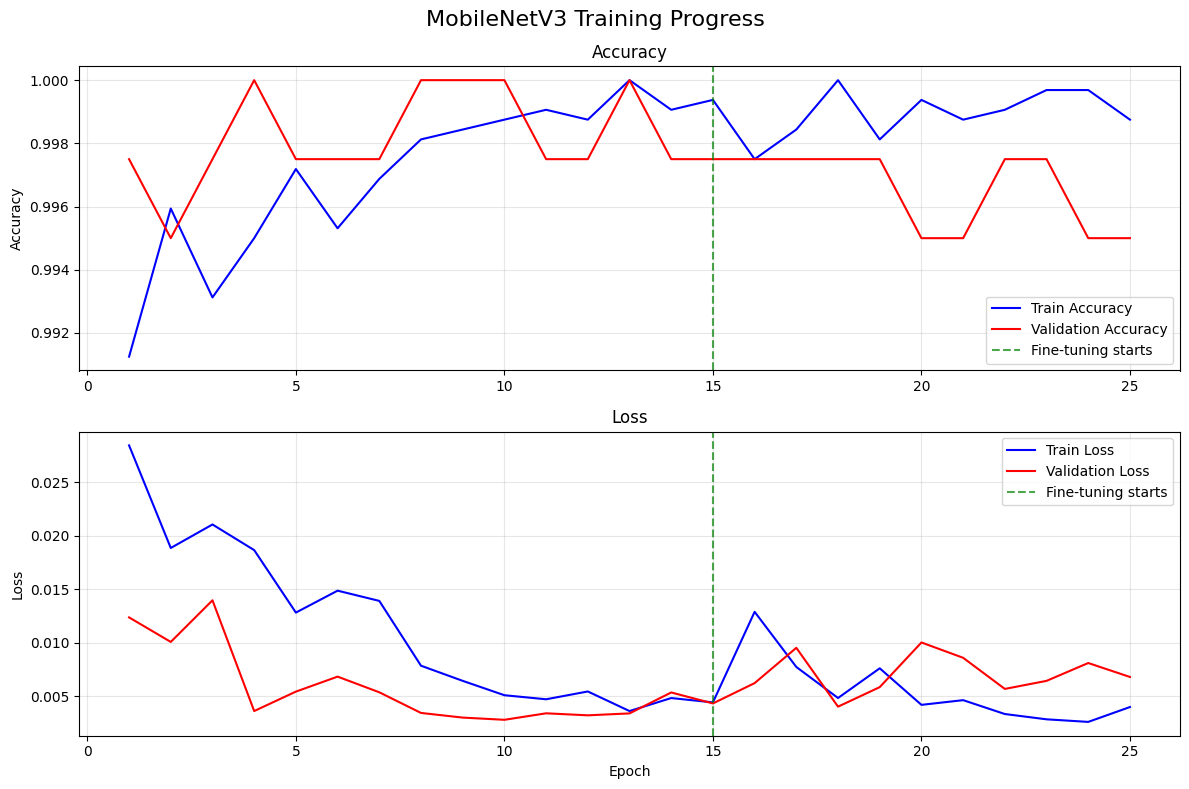

In [22]:
# Visualização com matplotlib (alternativa ao Plotly)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Accuracy
ax1.plot(vals_combined['Epoch'], vals_combined['Train Accuracy'], 'b-', label='Train Accuracy')
ax1.plot(vals_combined['Epoch'], vals_combined['Validation Accuracy'], 'r-', label='Validation Accuracy')
ax1.axvline(x=phase1_epochs, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(vals_combined['Epoch'], vals_combined['Train Loss'], 'b-', label='Train Loss')
ax2.plot(vals_combined['Epoch'], vals_combined['Validation Loss'], 'r-', label='Validation Loss')
ax2.axvline(x=phase1_epochs, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('MobileNetV3 Training Progress', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
_history_dict = .history
if not _history_dict:
    vals = pd.DataFrame()  # Create an empty DataFrame if history is empty
else:
    # Find the minimum length of all metric lists.
    # This handles cases where some lists might be empty (len=0), making min_length=0.
    # It assumes all values in _history_dict are iterables for which len() is defined (e.g., lists),
    # which is standard for Keras history.history.
    min_length = min(len(v) for v in _history_dict.values())
    
    # Truncate all lists in the history dictionary to this minimum length.
    # If min_length is 0, all lists in processed_history will become empty.
    processed_history = {key: value[:min_length] for key, value in _history_dict.items()}
    
    # Create the DataFrame from the processed history.
    # If processed_history contains empty lists, an empty DataFrame (with columns but no rows) will be created.
    vals = pd.DataFrame(processed_history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

NameError: name 'history' is not defined

In [ ]:
iplot(px.line(data_frame=vals,
              y = ["Train Accuracy","Validation Accuracy"],
              labels={"index":"epochs","value":"accuracy"},
              title = "Accuracy",
              template="plotly_dark"))

In [24]:
# Salvar o modelo
model.save('models/mobilenetv3_small.keras')

from tensorflow import keras
# model = keras.models.load_model('modelo_lcnn_versao4.keras')
model = keras.models.load_model('models/mobilenetv3_small.keras')

In [25]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 519ms/step


                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       1.00      1.00      1.00        50
         Healthy       1.00      1.00      1.00        50
  Powdery Mildew       1.00      1.00      1.00        50
     Sooty Mould       1.00      1.00      1.00        50

        accuracy                           1.00       400
       macro avg       1.00      1.00      1.00       400
    weighted avg       1.00      1.00      1.00       400



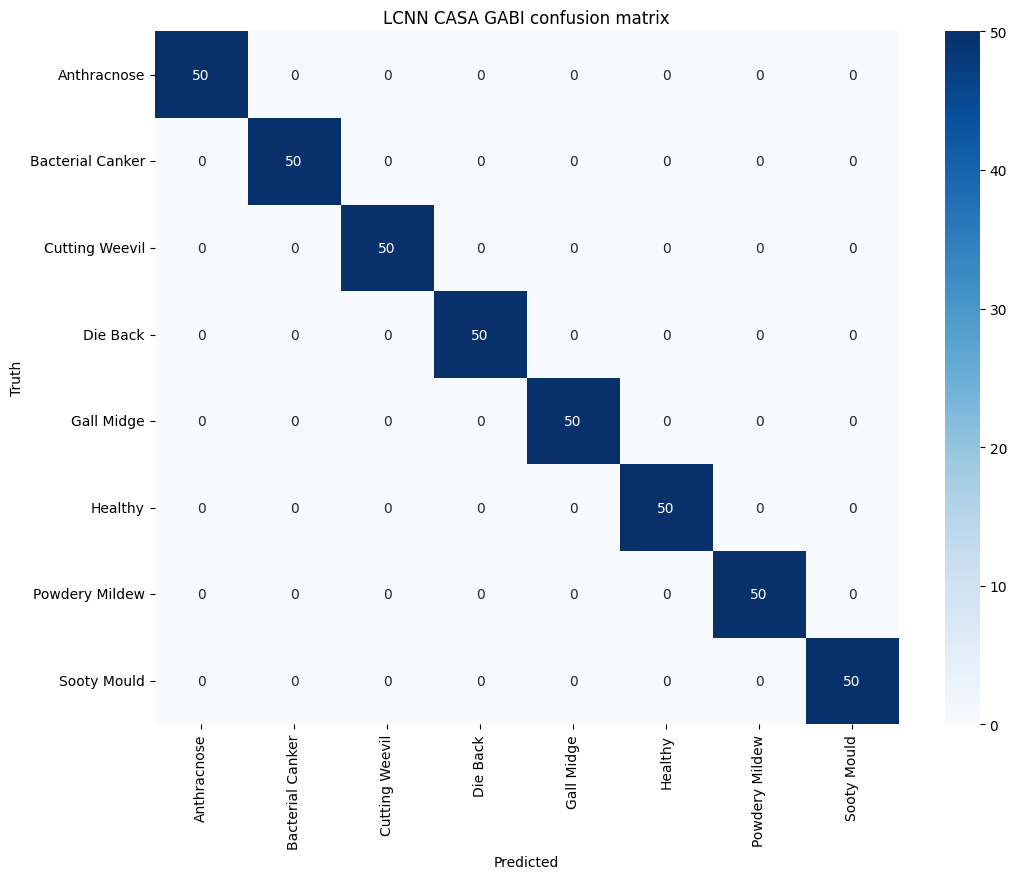

In [26]:
print(classification_report(y_true,y_pred, target_names=class_labels))

plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("LCNN CASA GABI confusion matrix")
plt.show()

In [27]:
# Verificar vazamento de dados (data leakage)
print("Verificando possível vazamento de dados:")
print(f"Total de amostras: {len(df)}")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Verificar se há sobreposição de arquivos
train_files = set(train_df['file_paths'])
test_files = set(test_df['file_paths'])
val_files = set(val_df['file_paths'])

overlap_train_test = train_files.intersection(test_files)
overlap_train_val = train_files.intersection(val_files)
overlap_test_val = test_files.intersection(val_files)

print(f"\nSobreposição train-test: {len(overlap_train_test)}")
print(f"Sobreposição train-val: {len(overlap_train_val)}")
print(f"Sobreposição test-val: {len(overlap_test_val)}")

# Verificar distribuição por classe
print("\nDistribuição no conjunto de teste:")
print(test_df['labels'].value_counts())

Verificando possível vazamento de dados:
Total de amostras: 4000
Train: 3200 (80.0%)
Val: 400 (10.0%)
Test: 400 (10.0%)

Sobreposição train-test: 0
Sobreposição train-val: 0
Sobreposição test-val: 0

Distribuição no conjunto de teste:
labels
Cutting Weevil      50
Die Back            50
Sooty Mould         50
Powdery Mildew      50
Healthy             50
Anthracnose         50
Bacterial Canker    50
Gall Midge          50
Name: count, dtype: int64


Confiança média das predições: 0.9983
Confiança mínima: 0.7453
Confiança máxima: 1.0000
Desvio padrão: 0.0141


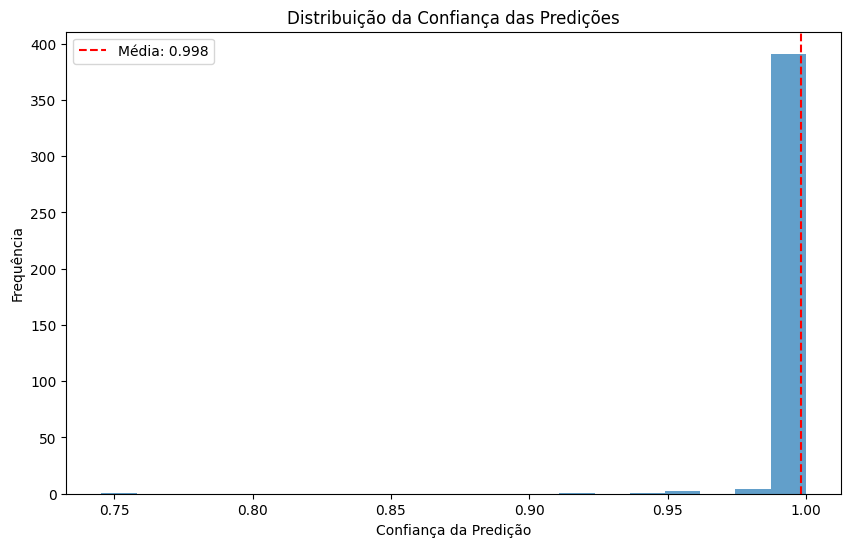


10 predições com menor confiança:
True: Sooty Mould, Pred: Sooty Mould, Conf: 0.7453
True: Gall Midge, Pred: Gall Midge, Conf: 0.9209
True: Anthracnose, Pred: Anthracnose, Conf: 0.9417
True: Gall Midge, Pred: Gall Midge, Conf: 0.9548
True: Powdery Mildew, Pred: Powdery Mildew, Conf: 0.9585
True: Healthy, Pred: Healthy, Conf: 0.9803
True: Gall Midge, Pred: Gall Midge, Conf: 0.9805
True: Gall Midge, Pred: Gall Midge, Conf: 0.9837
True: Sooty Mould, Pred: Sooty Mould, Conf: 0.9838
True: Sooty Mould, Pred: Sooty Mould, Conf: 0.9896


In [28]:
# Analisar confiança das predições
prediction_confidence = np.max(predictions, axis=1)
print(f"Confiança média das predições: {prediction_confidence.mean():.4f}")
print(f"Confiança mínima: {prediction_confidence.min():.4f}")
print(f"Confiança máxima: {prediction_confidence.max():.4f}")
print(f"Desvio padrão: {prediction_confidence.std():.4f}")

# Visualizar distribuição de confiança
plt.figure(figsize=(10, 6))
plt.hist(prediction_confidence, bins=20, alpha=0.7)
plt.xlabel('Confiança da Predição')
plt.ylabel('Frequência')
plt.title('Distribuição da Confiança das Predições')
plt.axvline(prediction_confidence.mean(), color='red', linestyle='--', label=f'Média: {prediction_confidence.mean():.3f}')
plt.legend()
plt.show()

# Mostrar algumas predições com menor confiança
low_confidence_idx = np.argsort(prediction_confidence)[:10]
print("\n10 predições com menor confiança:")
for idx in low_confidence_idx:
    true_class = class_labels[y_true[idx]]
    pred_class = class_labels[y_pred[idx]]
    confidence = prediction_confidence[idx]
    print(f"True: {true_class}, Pred: {pred_class}, Conf: {confidence:.4f}")